In [1]:
import pandas as pd

df = pd.read_csv("heart.csv", encoding="latin1")
df.head()


,Age,Age_Normalization,Min_max_scaling_age,Sex,Chest_pain_type,Resting_bp,Resting_bp_normalization,Cholesterol,Cholesterol_normalization,Fasting_blood_sugar,...,Oldpeak_normalization,Slope,Major_vessels,Thalassemia,Unnamed: 19,age_bin,chol_risk,bp_risk,age×chol,target
0,29,-2.809529,0.000000,Male,Atypical angina,130,-0.091249,204,-0.821201,0,...,-0.898054,Downsloping,0,Reversible defect,NaN,2029,Borderline,Elevated,5916,Heart disease
1,34,-2.256918,0.104167,Female,Atypical angina,118,-0.774489,210,-0.705266,0,...,NaN,Downsloping,0,Reversible defect,NaN,3039,Borderline,Normal,7140,Heart disease
2,34,-2.256918,0.104167,Male,Asymptomatic,118,-0.774489,182,-1.246293,0,...,NaN,Downsloping,0,Reversible defect,NaN,3039,Normal,Normal,6188,Heart disease
3,35,-2.146396,0.125000,Male,Typical angina,120,-0.660615,198,-0.937135,0,...,NaN,Flat,0,Reversible defect,NaN,3039,Normal,Elevated,6930,No heart disease
4,35,-2.146396,0.125000,Female,Typical angina,138,0.364243,183,-1.226970,0,...,NaN,Downsloping,0,Reversible defect,NaN,3039,Normal,Elevated,6405,Heart disease


Columns after renaming:
 Index(['Age', 'Age_Normalization', 'Min_max_scaling_age', 'sex', 'cp',
       'resting_bp', 'Resting_bp_normalization', 'cholesterol',
       'Cholesterol_normalization', 'Fasting_blood_sugar',
       'Resting_electrocardiographic', 'max_hr',
       'Max_heart_rate_normalization', 'exercise induced angina ', 'oldpeak',
       'Oldpeak_normalization', 'Slope', 'Major_vessels ', 'thal', 'age_bin',
       'chol_risk', 'bp_risk', 'age×chol', 'target', 'age_group', 'sex_label',
       'sex_num'],
      dtype='object')

Unique values in target after mapping: [1 0]

Q1 – counts by age group and target:
   age_group  target  count
0     20–29       0      0
1     20–29       1      1
2     30–39       0      4
3     30–39       1     10
4     40–49       0     22


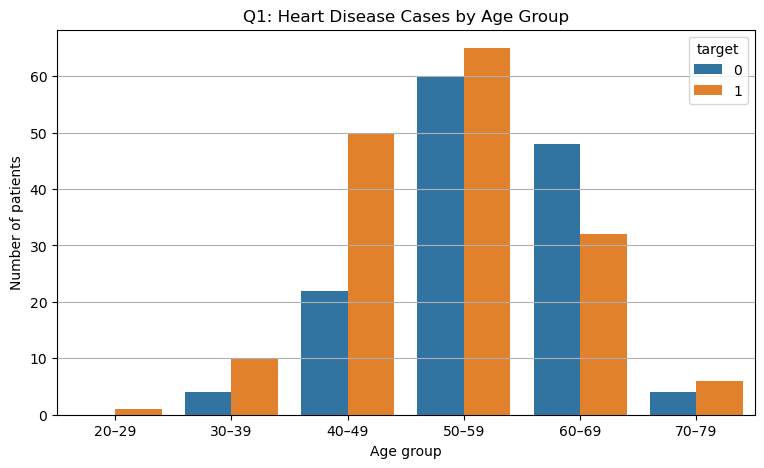


Q2 – disease rate by sex:
   sex_label      rate
0    Female  0.750000
1      Male  0.446602


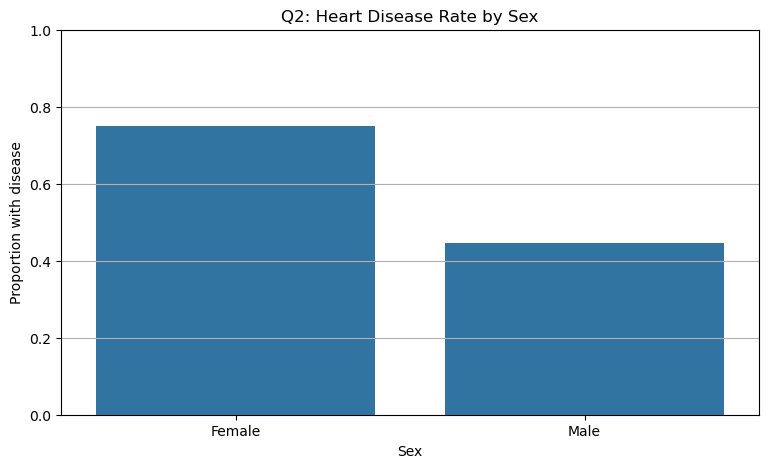

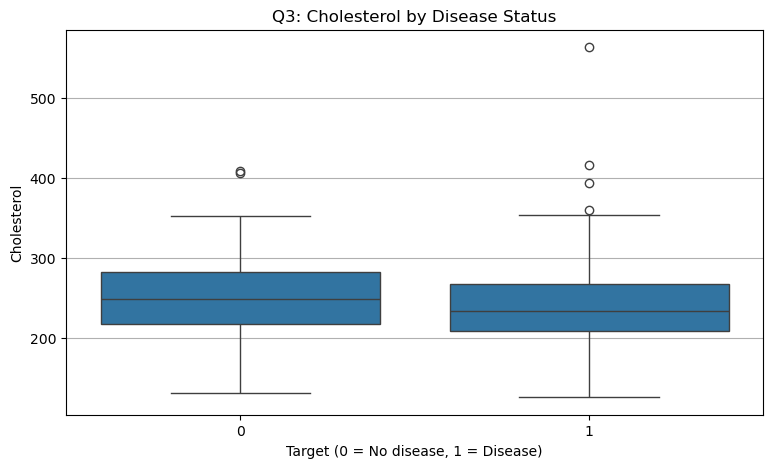

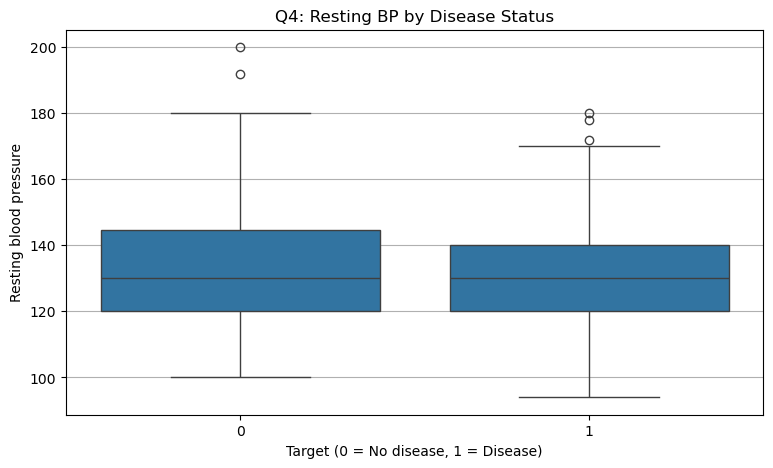

ValueError: could not convert string to float: 'Atypical angina'

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True

# ---------- Clean up columns based on your actual dataset ----------

# Drop useless unnamed column if present
if 'Unnamed: 19' in df.columns:
    df = df.drop(columns=['Unnamed: 19'])

# Rename a few columns to simpler names
rename_map = {
    'Resting_bp': 'resting_bp',
    'Max_ heart_rate ': 'max_hr',   # exactly as in df.columns
    'Oldpeak': 'oldpeak'
}
df.rename(columns=rename_map, inplace=True)

print("Columns after renaming:\n", df.columns)

# Convert target ("Heart disease"/"No heart disease") to numeric 1/0
if df['target'].dtype == 'object':
    df['target'] = df['target'].str.strip().map({
        'Heart disease': 1,
        'No heart disease': 0
    })

print("\nUnique values in target after mapping:", df['target'].unique())

# ======================================================
# Q1 – Age Group Distribution
# ======================================================

age_bins = [20, 30, 40, 50, 60, 70, 80]
age_labels = ['20–29', '30–39', '40–49', '50–59', '60–69', '70–79']

df['age_group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

age_group_counts = df.groupby(['age_group', 'target'], observed=False).size().reset_index(name='count')
print("\nQ1 – counts by age group and target:\n", age_group_counts.head())

plt.figure()
sns.barplot(data=age_group_counts, x='age_group', y='count', hue='target')
plt.title("Q1: Heart Disease Cases by Age Group")
plt.xlabel("Age group")
plt.ylabel("Number of patients")
plt.show()

# ======================================================
# Q2 – Heart Disease by Sex
# ======================================================

# Your column is 'sex' (0/1), so map it to labels
if df['sex'].dtype != 'object':
    df['sex_label'] = df['sex'].map({0: 'Female', 1: 'Male'})
else:
    df['sex_label'] = df['sex']

sex_rate = df.groupby('sex_label')['target'].mean().reset_index()
sex_rate.rename(columns={'target': 'rate'}, inplace=True)
print("\nQ2 – disease rate by sex:\n", sex_rate)

plt.figure()
sns.barplot(data=sex_rate, x='sex_label', y='rate')
plt.title("Q2: Heart Disease Rate by Sex")
plt.xlabel("Sex")
plt.ylabel("Proportion with disease")
plt.ylim(0, 1)
plt.show()

# ======================================================
# Q3 – Cholesterol vs Heart Disease
# ======================================================

plt.figure()
sns.boxplot(data=df, x='target', y='cholesterol')
plt.title("Q3: Cholesterol by Disease Status")
plt.xlabel("Target (0 = No disease, 1 = Disease)")
plt.ylabel("Cholesterol")
plt.show()

# ======================================================
# Q4 – Resting Blood Pressure vs Heart Disease
# ======================================================

plt.figure()
sns.boxplot(data=df, x='target', y='resting_bp')
plt.title("Q4: Resting BP by Disease Status")
plt.xlabel("Target (0 = No disease, 1 = Disease)")
plt.ylabel("Resting blood pressure")
plt.show()




use_cols = [c for c in corr_cols if c in df.columns]
corr = df[use_cols].corr()

# ======================================================
# Q5 – Multivariate Predictor Analysis (YOUR PART)
# ======================================================

# --- Make numeric versions of sex, cp, thal for modeling/correlation ---

# sex_num: 0 = Female, 1 = Male
if 'sex_num' not in df.columns:
    if df['sex'].dtype == 'object':
        df['sex_num'] = df['sex'].str.strip().map({'Male': 1, 'Female': 0})
    else:
        df['sex_num'] = df['sex']

# cp_num: integer codes for chest pain type
if 'cp_num' not in df.columns:
    if df['cp'].dtype == 'object':
        df['cp_num'], _ = pd.factorize(df['cp'])
    else:
        df['cp_num'] = df['cp']

# thal_num: integer codes for thalassemia
if 'thal_num' not in df.columns:
    if df['thal'].dtype == 'object':
        df['thal_num'], _ = pd.factorize(df['thal'])
    else:
        df['thal_num'] = df['thal']

# ---- Correlation matrix using only numeric columns ----
corr_cols = ['Age', 'cholesterol', 'resting_bp', 'max_hr', 'oldpeak',
             'sex_num', 'cp_num', 'thal_num', 'target']

use_cols = [c for c in corr_cols if c in df.columns]
print("\nQ5 – columns used in correlation:", use_cols)

corr = df[use_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Q5: Correlation Matrix of Heart Disease Predictors")
plt.show()

# ---- Logistic Regression using numeric features ----
predictors = [c for c in ['Age','cholesterol','resting_bp','max_hr',
                          'oldpeak','sex_num','cp_num','thal_num']
              if c in df.columns]

print("\nQ5 – predictors used in logistic regression:", predictors)

X = df[predictors]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nQ5 – Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

# ---- Chest pain vs disease (can use text labels here) ----
plt.figure()
sns.barplot(data=df, x='cp', y='target', estimator=np.mean)
plt.title("Q5: Heart Disease Rate by Chest Pain Type")
plt.xlabel("Chest pain type (cp)")
plt.ylabel("Disease prevalence")
plt.xticks(rotation=20)
plt.show()



In [4]:
df.columns


Index(['Age', 'Age_Normalization', 'Min_max_scaling_age', 'sex', 'cp',
       'Resting_bp', 'Resting_bp_normalization', 'cholesterol',
       'Cholesterol_normalization', 'Fasting_blood_sugar',
       'Resting_electrocardiographic', 'Max_ heart_rate ',
       'Max_heart_rate_normalization', 'exercise induced angina ', 'Oldpeak',
       'Oldpeak_normalization', 'Slope', 'Major_vessels ', 'thal',
       'Unnamed: 19', 'age_bin', 'chol_risk', 'bp_risk', 'age×chol', 'target',
       'age_group'],
      dtype='object')

In [6]:
required_cols = ['Age', 'cholesterol', 'resting_bp', 'max_hr', 'oldpeak', 'sex', 'cp', 'thal', 'target']

missing = [c for c in required_cols if c not in df.columns]
missing


[]

Unique target values: [1 0]
Columns used for Q5 correlation: ['Age', 'cholesterol', 'resting_bp', 'max_hr', 'oldpeak', 'sex_num', 'cp_num', 'thal_num', 'target']


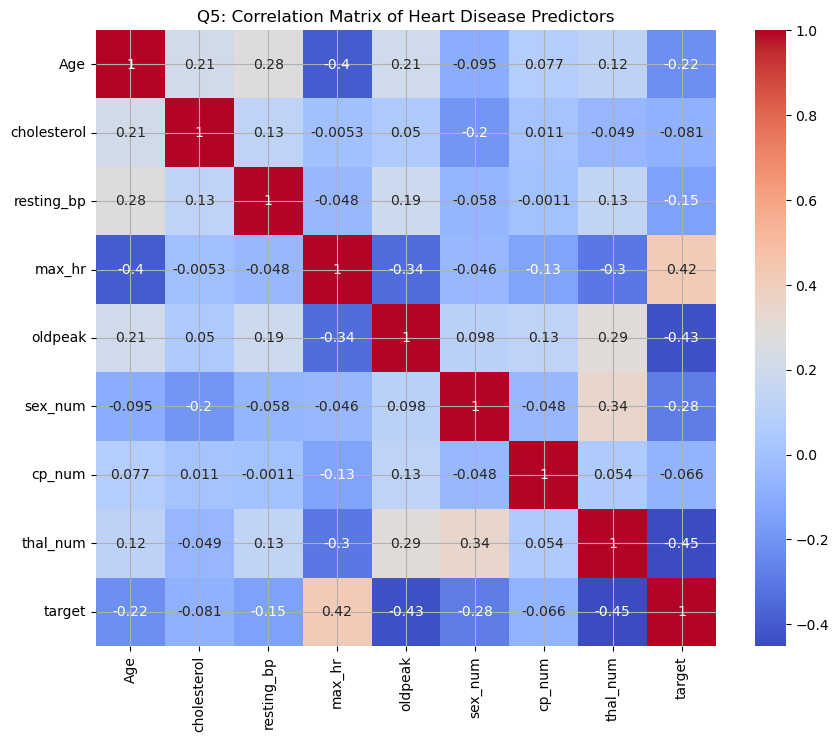


Q5 – Logistic Regression Accuracy: 0.7692307692307693

Classification report:

              precision    recall  f1-score   support

           0       0.78      0.72      0.75        43
           1       0.76      0.81      0.79        48

    accuracy                           0.77        91
   macro avg       0.77      0.77      0.77        91
weighted avg       0.77      0.77      0.77        91



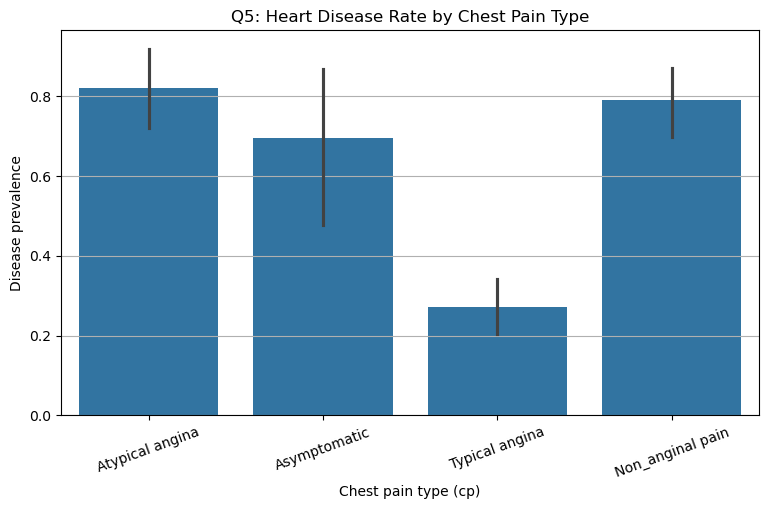

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# ---------- Make sure target is numeric 0/1 ----------
if df['target'].dtype == 'object':
    df['target'] = df['target'].str.strip().map({
        'Heart disease': 1,
        'No heart disease': 0
    })

print("Unique target values:", df['target'].unique())

# ---------- Create numeric versions of sex, cp, thal ----------
# sex_num: 0 = Female, 1 = Male
if df['sex'].dtype == 'object':
    df['sex_num'] = df['sex'].str.strip().map({'Female': 0, 'Male': 1})
else:
    df['sex_num'] = df['sex']

# cp_num: numeric code for chest pain type
df['cp_num'], _ = pd.factorize(df['cp'])

# thal_num: numeric code for thalassemia
df['thal_num'], _ = pd.factorize(df['thal'])

# pick correct oldpeak column name
oldpeak_col = 'oldpeak' if 'oldpeak' in df.columns else 'Oldpeak'

# ---------- Correlation Matrix (Q5) ----------
corr_cols = ['Age', 'cholesterol', 'resting_bp', 'max_hr',
             oldpeak_col, 'sex_num', 'cp_num', 'thal_num', 'target']

corr_cols = [c for c in corr_cols if c in df.columns]
print("Columns used for Q5 correlation:", corr_cols)

corr = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Q5: Correlation Matrix of Heart Disease Predictors")
plt.show()

# ---------- Logistic Regression (Q5) ----------
predictors = [c for c in corr_cols if c != 'target']
X = df[predictors]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nQ5 – Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

# ---------- Chest pain vs disease barplot ----------
plt.figure()
sns.barplot(data=df, x='cp', y='target', estimator=np.mean)
plt.title("Q5: Heart Disease Rate by Chest Pain Type")
plt.xlabel("Chest pain type (cp)")
plt.ylabel("Disease prevalence")
plt.xticks(rotation=20)
plt.show()
